In [1]:

import numpy as np
import pprint
pp = pprint.PrettyPrinter(depth = 2)
import re
from utils import *
import pickle
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
from sklearn.metrics import r2_score
from matplotlib.colors import LogNorm
from math import ceil
from scipy.stats import pearsonr
import copy
import itertools
from sklearn.linear_model import LinearRegression

# Load in the data

In [2]:
with open(os.path.join("data", "data_clean_no_letters.pickle"), "rb") as f:
    datar = pickle.load(f)

In [3]:
github_metadata            = datar.github_metadata
google_play_metadata       = datar.google_play_metadata
github_names               = datar.github_names
all_release_metadata       = datar.all_release_metadata
all_reviews_from_github    = datar.all_reviews_from_github

In [4]:
len(github_names)

415

# <b>RQ 1 :</b> What is the correlation between app release frequency and user engagement metrics (e.g., number of ratings and installs)?

## Helper functions

In [5]:
def extract_version(version_string):
    if version_string is None: return None
    search = re.search('(\d+.\d+.\d+)', version_string)
    return search.group(1) if search else None

In [6]:
def parse_reviews(reviews):
    
    review_metrics = defaultdict(defaultdict)

    for review in reviews:
        version = extract_version(review["reviewCreatedVersion"])
        
        if version is None: continue
        
        if version not in review_metrics.keys():
            review_metrics[version] = {
                "count"         : 0,
                "total_score"   : 0
            }

        review_metrics[version]["count"] += 1
        review_metrics[version]["total_score"] += review["score"]

    return review_metrics

In [7]:
def parse_releases(releases):
    
    release_metrics = dict()
    
    to_datetime = lambda x : datetime.fromisoformat(x[:-1] + '+00:00')
    duration = lambda x : (to_datetime(x["end_date"]) - to_datetime(x["start_date"])).total_seconds()

    for release in releases:
        version = extract_version(release["release_data"]["tag_name"])
        
        if version is None: continue
        
        if version not in release_metrics.keys():
            release_metrics[version] = {
                "duration" : 0
            }
        
        release_metrics[version]["duration"] = duration(release)
    
    return release_metrics

In [8]:
def compute_values_per_version(key):
    
    # Compute update frequencies
    releases        = all_release_metadata[key]
    release_metrics = parse_releases(releases)
    
    # Compute review metrics
    reviews         = all_reviews_from_github[key]
    review_metrics  = parse_reviews(reviews)
    
    for (k, v) in review_metrics.items():
        if v["count"] != 0:
            review_metrics[k]["avg_score"] = v["total_score"] / v["count"]
        else:
            review_metrics[k]["avg_score"] = None
            
    # Join metrics
    metrics = defaultdict(lambda : defaultdict(int))
    
    for version in release_metrics.keys():
        
        for release_name, release_value in release_metrics[version].items():
            metrics[version][release_name] = release_value
            
        for review_name, review_value in review_metrics[version].items():
            metrics[version][review_name] = review_value
            
    return metrics
    

In [9]:
def compute_all_values():
    metrics = dict()
    
    for key in all_release_metadata.keys():
        metrics[key] = compute_values_per_version(key)
        
    return metrics

In [10]:
def flatten_dict(m, param_list):
    output_dict = defaultdict(list)
    for (name, metrics_per_version) in m.items():
        for metrics in metrics_per_version.values():
            
            for param in param_list:
                output_dict[param].append(metrics[param])
                
    return output_dict

In [11]:
# Compute all the metrics
metrics_per_version = compute_all_values()
metrics = flatten_dict(metrics_per_version, ["duration", "count", "avg_score"])

In [12]:
def rq1_plot(x, y, x_label, y_label):
    fig = plt.figure()

    gs = GridSpec(4,4)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    ax_color = fig.add_subplot(gs[0, 3])

    im = ax_joint.hexbin(x, y, cmap = "viridis", gridsize = 25, norm = LogNorm())
    
    fig.colorbar(im, cax = ax_color, orientation = 'vertical')
    
    # Plot best line fit
    z = np.polyfit(x, y, 1) 
    # r_squared = r2_score(x, y)
    ax_joint.plot(np.unique(x), np.poly1d(z)(np.unique(x)), label=("y=%.2fx+%.2f"%(z[0],z[1])))
    
    nbins = 30

    # Plot marginals
    x_bins = np.arange(nbins + 1) * (np.max(x) - np.min(x)) / nbins + np.min(x)
    x_kde = stats.gaussian_kde(x)
    xx = np.linspace(np.min(x), np.max(x), 1000)
    ax_marg_x.hist(x, bins = x_bins, density = True, color="steelblue")
    ax_marg_x.plot(xx, x_kde(xx), color="blue")

    y_bins = np.arange(nbins + 1) * (np.max(y) - np.min(y)) / nbins + np.min(y)
    y_kde = stats.gaussian_kde(y)
    yy = np.linspace(np.min(y), np.max(y), 1000)
    ax_marg_y.hist(y, bins = y_bins, density = True, color="green", orientation="horizontal")
    ax_marg_y.plot(y_kde(yy), yy, color="limegreen")

    # Turn off tick labels on marginals
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel(x_label)
    ax_joint.set_ylabel(y_label)
    
    ax_joint.legend(loc = 'upper left')
    plt.show()

## Results

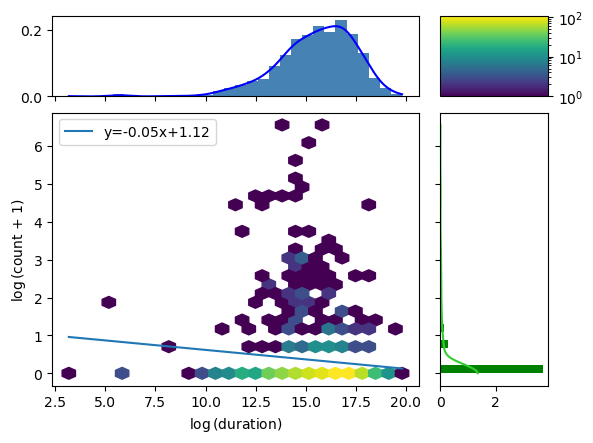

In [13]:
x, y = np.log(np.array(metrics["duration"])), np.log(np.array(metrics["count"]) + 1)
x_label, y_label = r"$\log$(duration)", r"$\log$(count + 1)" 
rq1_plot(x, y, x_label, y_label)

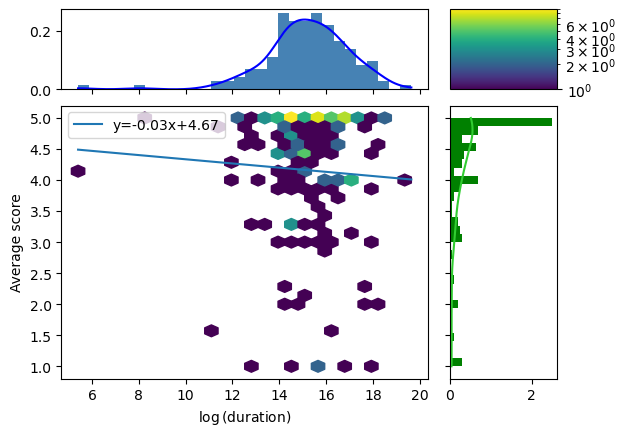

In [14]:
y = np.array(metrics["avg_score"])
x = np.log(np.array(metrics["duration"]))
idxs = y != 0
x, y = x[idxs], y[idxs]
x_label, y_label = r"$\log$(duration)", r"Average score" 
rq1_plot(x, y, x_label, y_label)

# <b>RQ 2 : </b>What characteristics are associated with app releases that experience an increasing in average rating of 2 points / 50 %?

In [15]:
def version_updates(app_metrics):
    
    updates = list()
    
    versions = np.sort(np.array(list(app_metrics.keys())))
    
    n = versions.shape[0]
    
    if n <= 1:
        return updates
    
    for v1, v2 in itertools.combinations(range(n), 2):

        # Get the version strings
        key1     = versions[v1]
        key2     = versions[v2]

        # Obtain the metrics
        score1   = app_metrics[key1]["avg_score"]
        score2   = app_metrics[key2]["avg_score"]
        count1   = app_metrics[key1]["count"]
        count2   = app_metrics[key2]["count"] 

        if count1 != 0 and count2 != 0:
            updates.append({
                "version1" : key1, 
                "version2" : key2, 
                "score1" : score1,
                "score2" : score2
                })

        
    return updates

In [16]:
updates = list()
for key, value in metrics_per_version.items():
    l = version_updates(value)  
    # print(l)
    if len(l) > 0:
        updates.append([key, l])

print(updates)
print(sum(len(x[1]) for x in updates))

[[np.str_('Carapacik/WordlyPlus'), [{'version1': np.str_('2.0.1'), 'version2': np.str_('2.2.1'), 'score1': 1.0, 'score2': 1.5}]], [np.str_('DimensionDev/TesserPG-Android'), [{'version1': np.str_('0.4.0'), 'version2': np.str_('0.5.1'), 'score1': 5.0, 'score2': 4.5}]], [np.str_('Domi04151309/Power-App-for-Android'), [{'version1': np.str_('1.8.1'), 'version2': np.str_('1.8.3'), 'score1': 5.0, 'score2': 3.0}, {'version1': np.str_('1.8.1'), 'version2': np.str_('1.8.4'), 'score1': 5.0, 'score2': 3.6666666666666665}, {'version1': np.str_('1.8.1'), 'version2': np.str_('1.8.6'), 'score1': 5.0, 'score2': 4.0}, {'version1': np.str_('1.8.1'), 'version2': np.str_('1.8.7'), 'score1': 5.0, 'score2': 3.25}, {'version1': np.str_('1.8.1'), 'version2': np.str_('1.9.0'), 'score1': 5.0, 'score2': 2.8333333333333335}, {'version1': np.str_('1.8.3'), 'version2': np.str_('1.8.4'), 'score1': 3.0, 'score2': 3.6666666666666665}, {'version1': np.str_('1.8.3'), 'version2': np.str_('1.8.6'), 'score1': 3.0, 'score2':

In [17]:
def datapoints_per_metric(get_metrics):
    x = []
    y = []

    for (key, data_per_version) in metrics_per_version.items():
        for version, metrics in data_per_version.items():

            release_metadata = all_release_metadata[key]
            
            version_per_id = [extract_version(release_metadata[i]["release_data"]["tag_name"]) for i in range(len(release_metadata))]
            id_curr_version = version_per_id.index(version)
                   
            xval = metrics["avg_score"]
            yvals = []
            
            for get_metric in get_metrics:
                yval = get_metric(id_curr_version, release_metadata)
                
                if yval is not None and not np.isnan(yval):
                    yvals.append(yval)
                else:
                    yvals = None
                    break
            
            
            if xval is not None and yvals is not None and not np.isnan(xval):
                x.append(xval)
                y.append(yvals)

    return np.array(x), np.array(y)

## Check for correlations between variables

c:\Users\mgjfl\miniconda3\envs\datar\lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mgjfl\miniconda3\envs\datar\lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


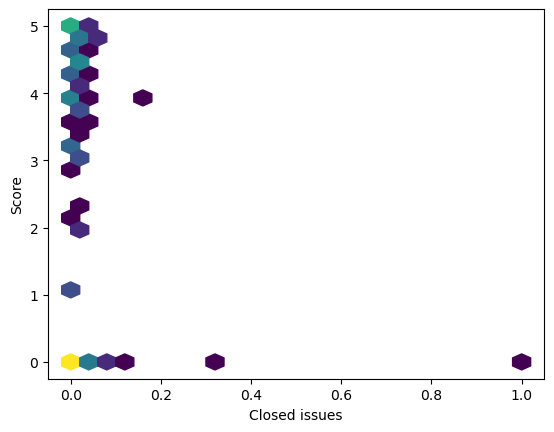

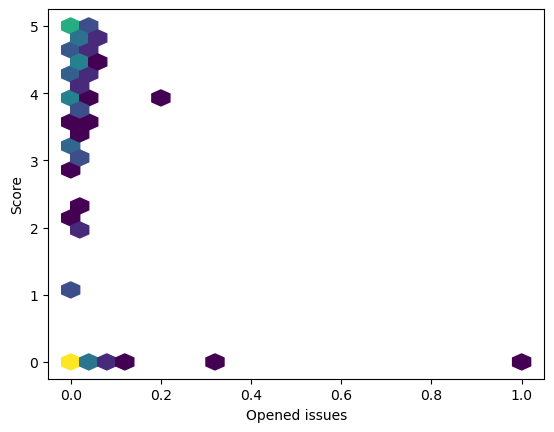

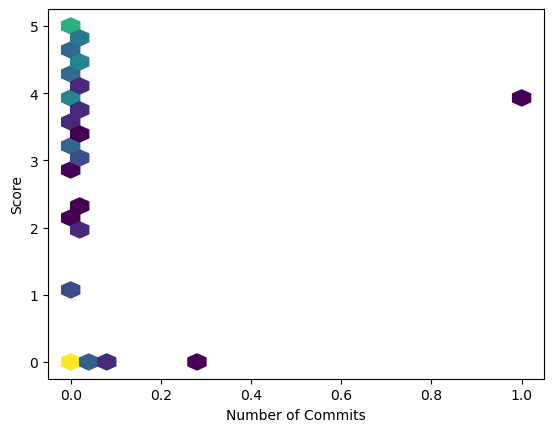

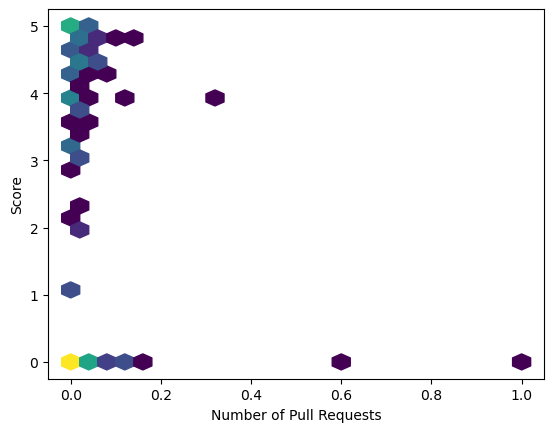

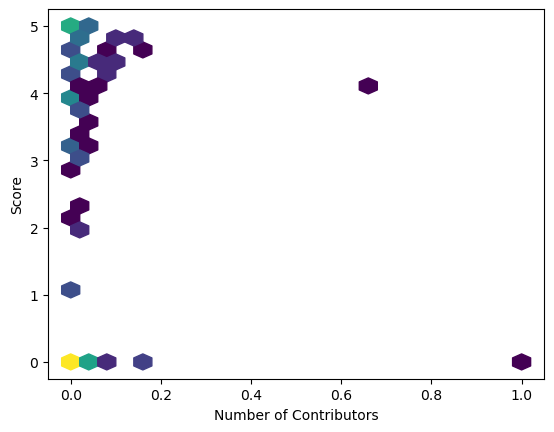

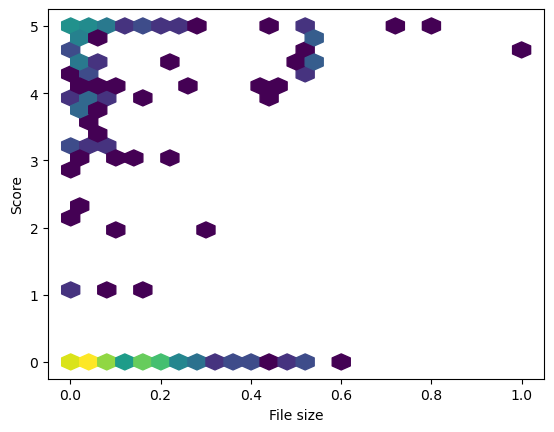

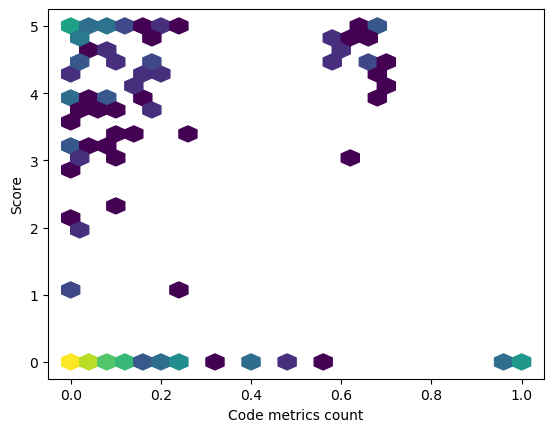

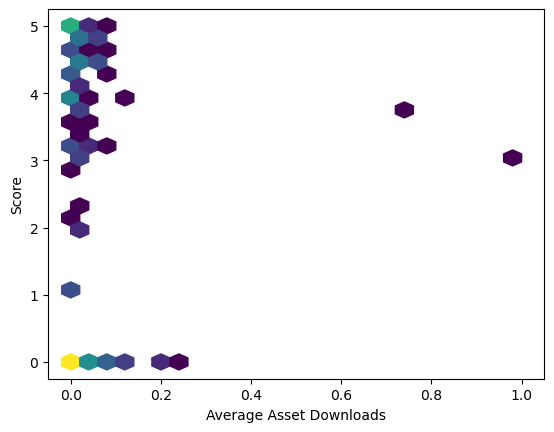

In [18]:
get_metrics = {
    "Closed issues" : lambda id, data : len(data[id]["closed_issues"]),
    "Opened issues" : lambda id, data : len(data[id]["created_issues"]),
    "Number of Commits" : lambda id, data : len(data[id]["commits"]),
    "Number of Pull Requests" : lambda id, data : len(data[id]["pull_requests"]),
    "Number of Contributors" : lambda id, data : len(data[id]["contributors"]),
    "File size" : lambda id, data : data[id]["apk_metrics"]["fileSize"] if data[id]["apk_metrics"] is not None else None,
    # "Dex size" : lambda id, data : data[id]["apk_metrics"]["dexSize"] if data[id]["apk_metrics"] is not None else None,
    "Code metrics count" : lambda id, data : sum(map(lambda x : x["count"], data[id]["code_metrics"].values())) if data[id]["code_metrics"] is not None else None,
    "Average Asset Downloads" : lambda id, data : np.mean(list(map(lambda x : x["download_count"], data[id]["release_data"]["assets"])))
}

y, x = datapoints_per_metric(list(get_metrics.values()))
for i in range(x.shape[1]):
    xt = x[:, i]
    xt = xt / xt.max()
    plt.hexbin(xt, y, gridsize = 25, norm = LogNorm())
    # plt.scatter(xt, y, label = list(get_metrics.keys())[i])
    # plt.xscale("log")
    
    plt.ylabel("Score")
    plt.xlabel(list(get_metrics.keys())[i])
        
    # plt.legend()
    plt.show()

In [19]:
def is_outlier(x):
    """
    Outliers are defined as being > 2 standard deviations from the mean
    """
    
    mean = x.mean()
    std  = x.std()
    return np.abs(x - mean) > 2 * std

In [20]:
def compute_rdd(x, threshold):
    idxs = x < threshold
    
    # print(threshold)
    
    try:
        
        # Fit left of threshold
        x_left = x[idxs]
        # print(x_left)
        y_left = y[idxs]
        linefit_left = stats.linregress(x_left, y_left)

        # Fit right of threshold
        x_right = x[~idxs]
        y_right = y[~idxs]
        linefit_right = stats.linregress(x_right, y_right)
    
    except:
        return None
    
    return {
        "x_left" : x_left,
        "y_left" : y_left,
        "linefit_left" : linefit_left,
        "x_right" : x_right,
        "y_right" : y_right,
        "linefit_right" : linefit_right,
    }

## Metrics when aggregating all values

In [32]:
def datapoints_per_metric_between_updates(updates, get_metrics):
    x = []
    y = []

    for (key, data_per_version) in updates:
        for data in data_per_version:

            version1 = data["version1"]
            version2 = data["version2"]

            score1 = data["score1"]
            score2 = data["score2"]

            release_metadata = all_release_metadata[key]
            version_per_id = [extract_version(release_metadata[i]["release_data"]["tag_name"]) for i in range(len(release_metadata))]

            id_prev_version = version_per_id.index(version1)
            id_curr_version = version_per_id.index(version2)


            perc_increase = lambda prev_v, curr_v, f : (f(curr_v, release_metadata) - f(prev_v, release_metadata)) / f(prev_v, release_metadata) * 100 \
                if f(curr_v, release_metadata) is not None and \
                   f(prev_v, release_metadata) is not None and \
                   f(prev_v, release_metadata) != 0 else None
                   
            yval = perc_increase(score1, score2, lambda x, y : x)
            xvals = []
            
            for get_metric in get_metrics:
                xval = perc_increase(id_prev_version, id_curr_version, get_metric)
                
                if xval is not None and not np.isnan(xval):
                    xvals.append(xval)
                else:
                    xvals = None
                    break
            
            
            if xvals is not None and yval is not None and not np.isnan(yval):
                x.append(xvals)
                y.append(yval)

    return np.array(x), np.array(y)

In [92]:
def plot_aggregated(get_metrics, exclude_zero_change = False, select_IQR = False):
    keys = list(get_metrics.keys())
    n = len(keys)

    fig, ax = plt.subplots(1, 1, figsize = (10, 5), sharex=True, sharey=True)


    for i in range(n):
        key = keys[i]
        x, y = datapoints_per_metric_between_updates(updates, [get_metrics[key]])
        x = x.flatten()
        
        # Sort on x coordinate
        sort_idxs = np.argsort(x)
        x = x[sort_idxs]
        y = y[sort_idxs]
        
        # Remove outliers
        non_outliers_y = ~is_outlier(y)
        non_outliers_x = ~is_outlier(x)
        non_outliers = np.logical_and(non_outliers_y, non_outliers_x)
        x = x[non_outliers]
        y = y[non_outliers]

        if exclude_zero_change:
            # Remove 0 change values
            non_zero_x = x != 0
            non_zero_y = y != 0
            non_zero = np.logical_and(non_zero_x, non_zero_y)
            x = x[non_zero]
            y = y[non_zero]
        

        try:
            linefit = True
            # Plot best line fit
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        except:
            linefit = False
            
        if select_IQR:
            q75, q25 = np.percentile(x, [75 ,25])
            idxs = np.logical_and(x > q25, x < q75)
            x = x[idxs]
            y = y[idxs]

        
        # z = np.polyfit(x, y, 1) 
        # r_squared = r2_score(x, y)
        # pearsonr_val = pearsonr(x, y).statistic
        
        # best_gof = -1
        

        # for i in range(3, len(x) - 3):
        #     threshold = (x[i] + x[i-1]) / 2
        #     rdd = compute_rdd(x, threshold)
            
        #     if rdd is None:
        #         continue
            
        #     rl = rdd["linefit_left"].rvalue**2
        #     rr = rdd["linefit_right"].rvalue**2
            
        #     gof = rl * rr #- (rl - rr)**2
            
        #     if gof > best_gof:
        #         best_threshold = threshold
        #         best_rdd = copy.deepcopy(rdd)
        #         best_gof = gof
        
        if linefit:
            ax.plot(np.unique(x), np.unique(x) * slope + intercept, label=(rf"y={slope:.2f}x+{intercept:.2f} ($R^2$ = {r_value**2:.2f}, p = {p_value:.2f})"))
        ax.scatter(x, y, label = key)
        # ax.plot(np.unique(best_rdd["x_left"]), np.unique(best_rdd["x_left"]) * best_rdd["linefit_left"].slope + best_rdd["linefit_left"].intercept, \
        #     label=(rf'y={best_rdd["linefit_left"].slope:.2f}x+{best_rdd["linefit_left"].intercept:.2f} ($R^2$ = {best_rdd["linefit_left"].rvalue**2:.2f})'))
        # ax.plot(np.unique(best_rdd["x_right"]), np.unique(best_rdd["x_right"]) * best_rdd["linefit_right"].slope + best_rdd["linefit_right"].intercept, \
        #     label=(rf'y={best_rdd["linefit_right"].slope:.2f}x+{best_rdd["linefit_right"].intercept:.2f} ($R^2$ = {best_rdd["linefit_right"].rvalue**2:.2f})'))
        # ax.plot(np.unique(x_right), np.unique(x_right) * slope_right + intercept_right, label=(rf"y={slope_right:.2f}x+{intercept_right:.2f} ($R^2$ = {r_value_right**2:.2f})"))
        # ax.axvline(best_threshold)
        
        ax.set_title(f"Max variation: {(x.max() - x.min()) * abs(slope):.1f}%")
        
    ax.set_xlabel("Percentual increase in metric")
    ax.set_ylabel("Percentual increase in average review score")
    ax.legend()

    # ax.set_ylim(-200, 1000)

    fig.suptitle("Percentual increase in values per score increase")
    
    return fig

c:\Users\mgjfl\miniconda3\envs\datar\lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mgjfl\miniconda3\envs\datar\lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


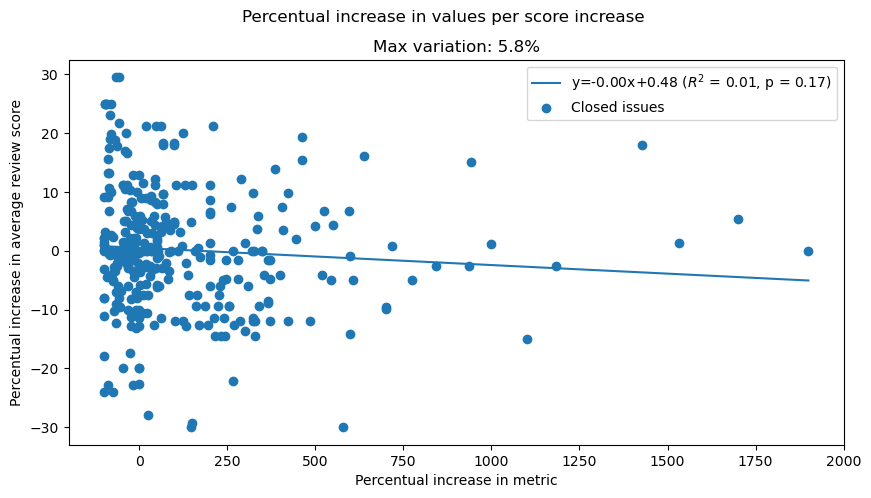

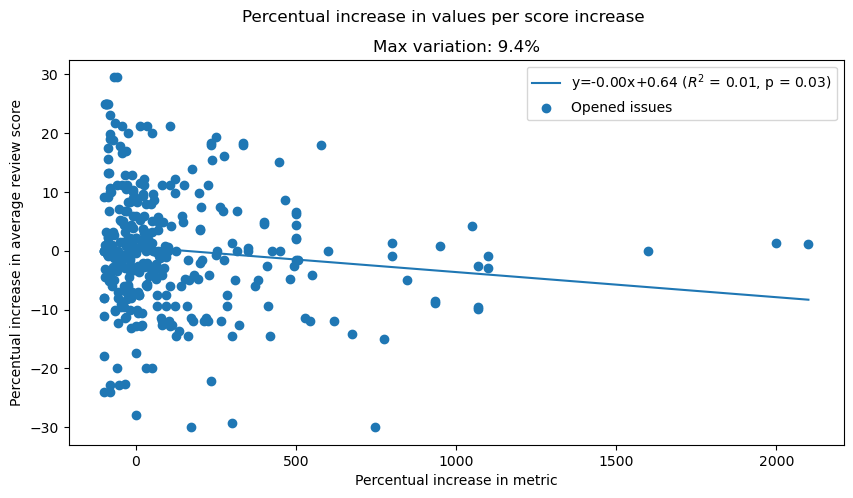

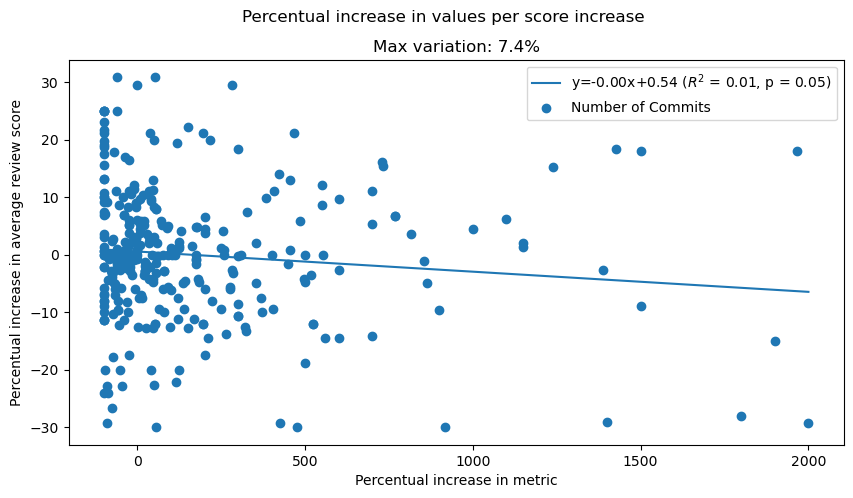

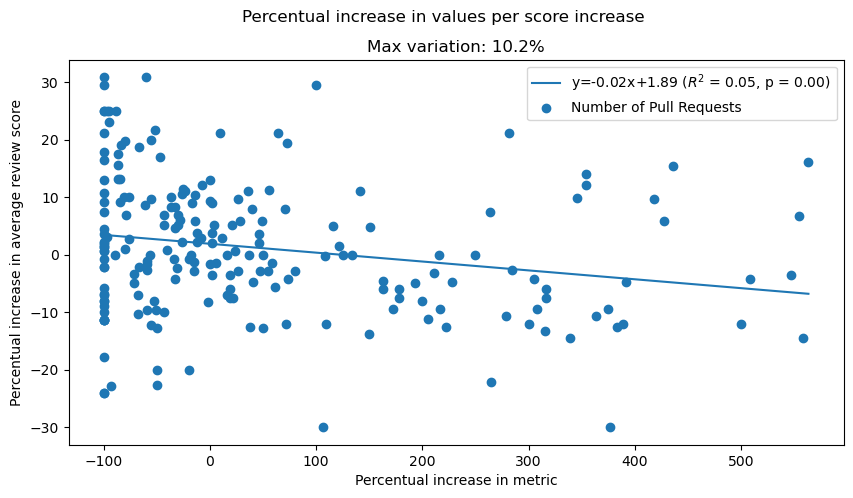

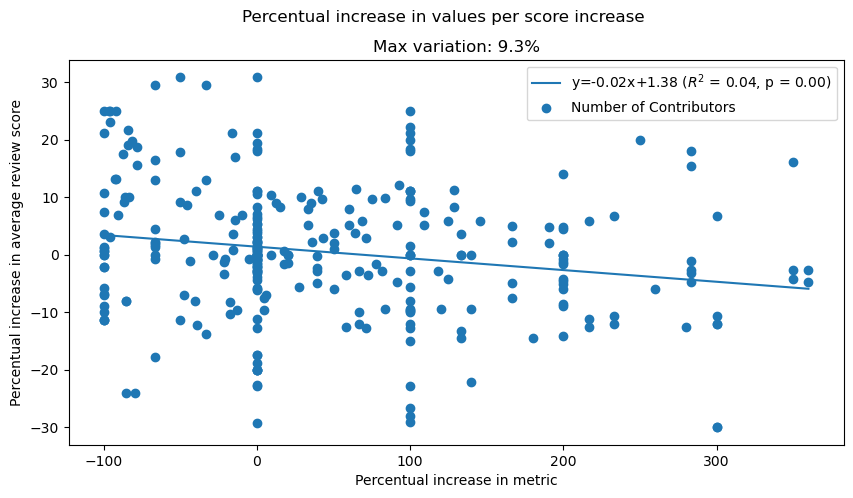

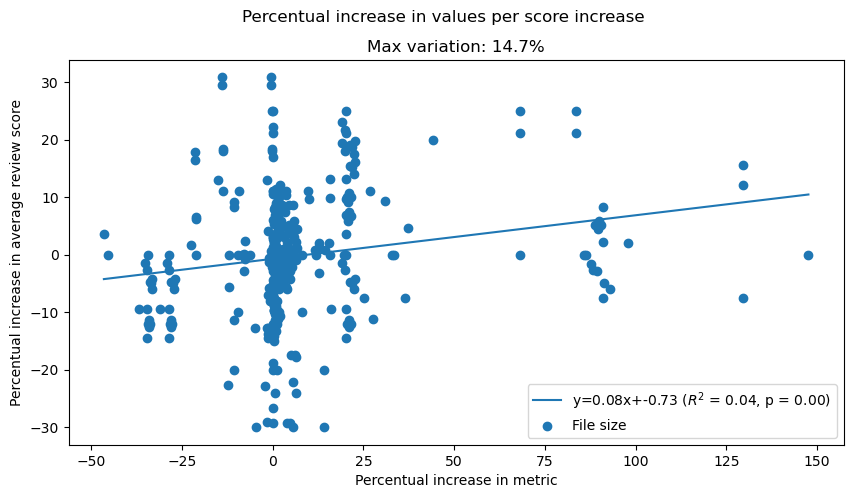

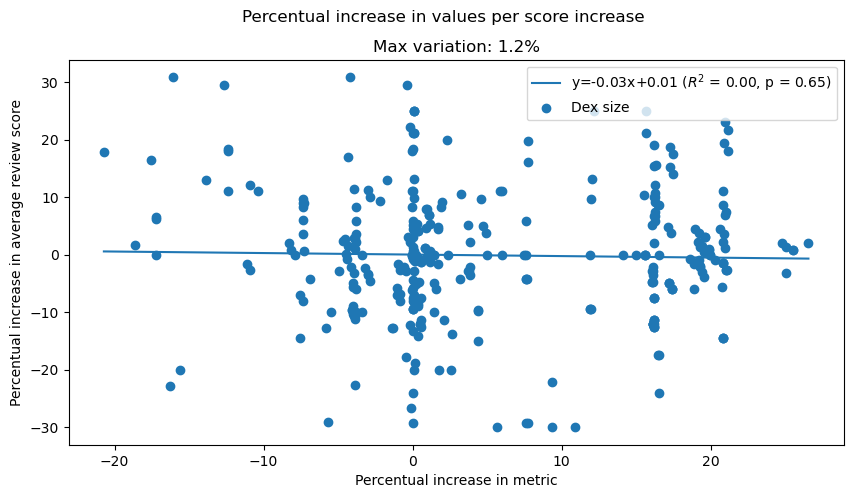

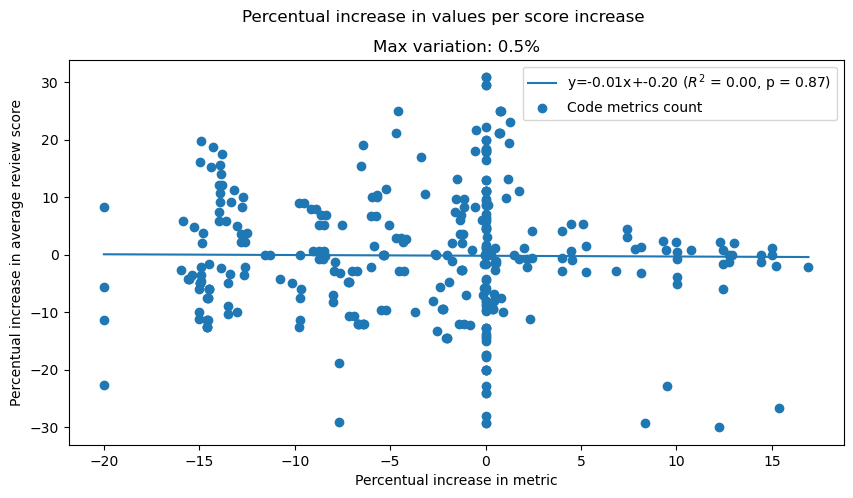

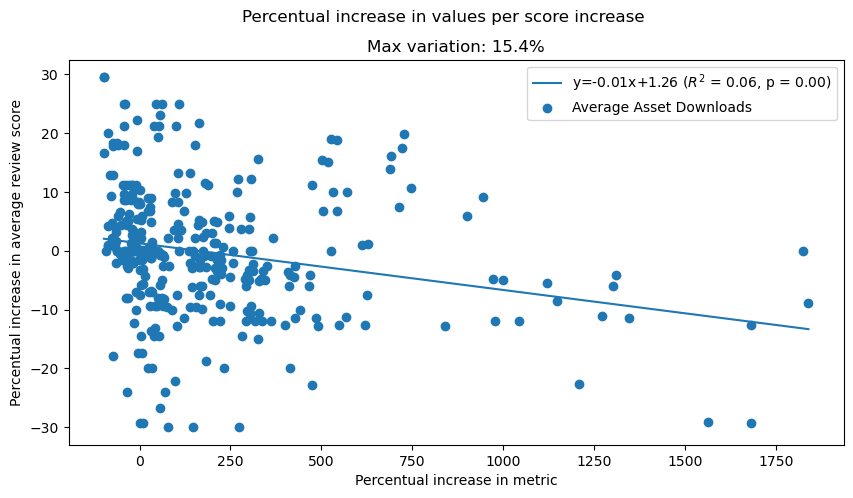

In [108]:
get_metrics = {
    "Closed issues" : lambda id, data : len(data[id]["closed_issues"]),
    "Opened issues" : lambda id, data : len(data[id]["created_issues"]),
    "Number of Commits" : lambda id, data : len(data[id]["commits"]),
    "Number of Pull Requests" : lambda id, data : len(data[id]["pull_requests"]),
    "Number of Contributors" : lambda id, data : len(data[id]["contributors"]),
    "File size" : lambda id, data : data[id]["apk_metrics"]["fileSize"] if data[id]["apk_metrics"] is not None else None,
    "Dex size" : lambda id, data : data[id]["apk_metrics"]["dexSize"] if data[id]["apk_metrics"] is not None else None,
    "Code metrics count" : lambda id, data : sum(map(lambda x : x["count"], data[id]["code_metrics"].values())) if data[id]["code_metrics"] is not None else None,
    "Average Asset Downloads" : lambda id, data : np.mean(list(map(lambda x : x["download_count"], data[id]["release_data"]["assets"])))
}

exclude_zeros = False
select_IQR = False

for (key, value) in get_metrics.items():

    fig = plot_aggregated({key : value}, exclude_zeros, select_IQR)
    fig.savefig(os.path.join("Figures", f"update_{key}_increase_excluding_{'true' if exclude_zeros else 'false'}_IQR_{'true' if select_IQR else 'false'}.png".replace(" ", "_")))

Multiple regression

In [67]:
get_metrics = {
    "Closed issues" : lambda id, data : len(data[id]["closed_issues"]),
    "Opened issues" : lambda id, data : len(data[id]["created_issues"]),
    "Number of Commits" : lambda id, data : len(data[id]["commits"]),
    "Number of Pull Requests" : lambda id, data : len(data[id]["pull_requests"]),
    "Number of Contributors" : lambda id, data : len(data[id]["contributors"]),
    "File size" : lambda id, data : data[id]["apk_metrics"]["fileSize"] if data[id]["apk_metrics"] is not None else 0,
    "Dex size" : lambda id, data : data[id]["apk_metrics"]["dexSize"] if data[id]["apk_metrics"] is not None else None,
    "Code metrics count" : lambda id, data : sum(map(lambda x : x["count"], data[id]["code_metrics"].values())) if data[id]["code_metrics"] is not None else 0,
    "Average Asset Downloads" : lambda id, data : np.mean(list(map(lambda x : x["download_count"], data[id]["release_data"]["assets"]))) if len(data[id]["release_data"]["assets"]) != 0 else 0
}

x, y = datapoints_per_metric_between_updates(updates, list(get_metrics.values()))

from sklearn.preprocessing import PolynomialFeatures

# Transform features to include polynomial terms up to degree 2
# poly = PolynomialFeatures(degree=3, include_bias=False)
# x = poly.fit_transform(x)

multiple_lin_regr = LinearRegression()
multiple_lin_regr.fit(x, y)

# Get the intercept and coefficients
intercept = multiple_lin_regr.intercept_
coefficients = multiple_lin_regr.coef_

# Predict values
y_pred = multiple_lin_regr.predict(x)

# Calculate the R^2 score
r2 = r2_score(y, y_pred)

# Output results
print("Intercept:", intercept)
print("Coefficients:", coefficients)
print("R^2 Score:", r2)


Intercept: 1.8643088895892395
Coefficients: [ 0.03260992 -0.04490765  0.02606781 -0.0287283  -0.00914332  0.05296773
  0.29502884 -0.21054995 -0.01941711]
R^2 Score: 0.18733284609137535


Distribution of released versions

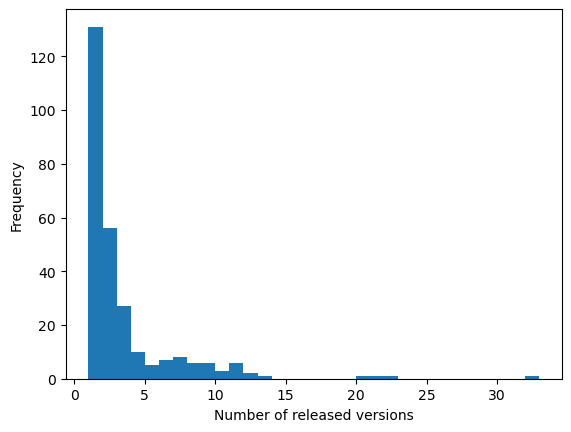

In [68]:
n_versions_0 = np.array(list(map(lambda x : len(x.keys()), metrics_per_version.values())))
n_versions = n_versions_0[n_versions_0 != 0]
bins = np.linspace(1, n_versions.max(), n_versions.max())
plt.hist(n_versions, bins = bins)
plt.xlabel("Number of released versions")
plt.ylabel("Frequency");

Individual analysis of popular applications

In [ ]:
popular_applications = np.array(list(metrics_per_version.keys()))[n_versions_0 >= 10]

# Must have at least 1 nonzero avg score
# idxs = [all(np.array(list(map(lambda x : x["avg_score"], metrics_per_version[key].values()))) != 0) for key in popular_applications]
idxs = [len(version_of_popularity_increase(metrics_per_version[app_name], lambda x, y : True)) > 2 for app_name in popular_applications]
popular_applications = popular_applications[idxs]


Computing metrics for LibChecker/LibChecker.

Computing metrics for kollerlukas/Camera-Roll-Android-App.

Computing metrics for organicmaps/organicmaps.

Computing metrics for tanujnotes/Olauncher.


C:\Users\mgjfl\AppData\Local\Temp\ipykernel_24660\3364807226.py:55: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_val = pearsonr(x, y).statistic


Text(0.5, 0.98, 'Percentual increase in values per score increase')

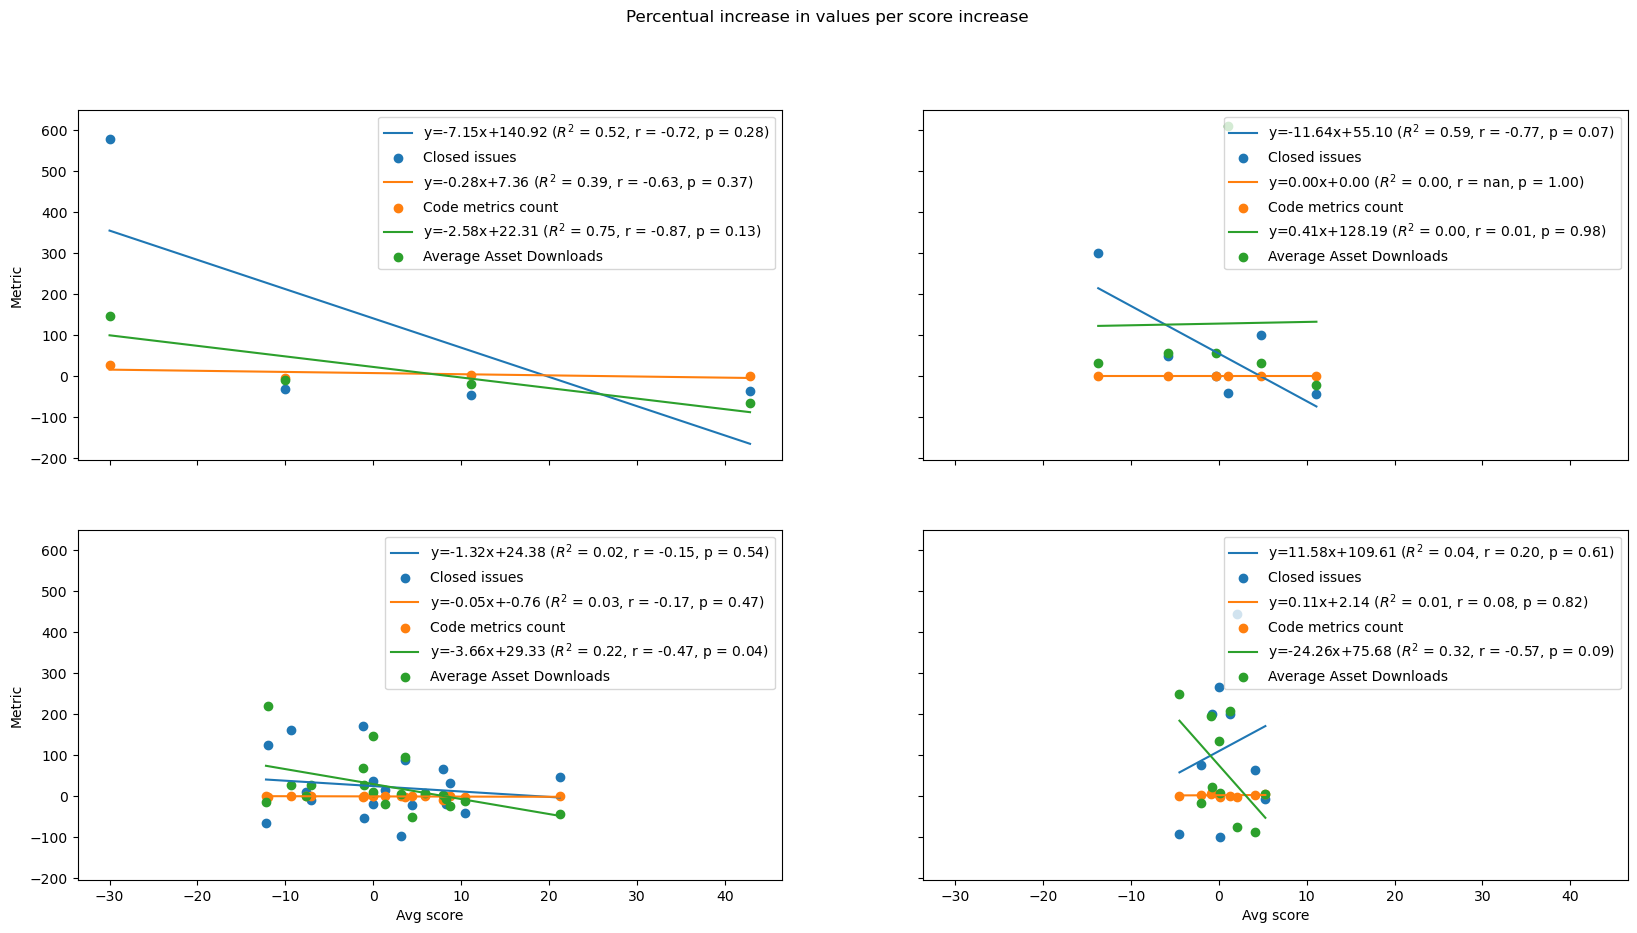

In [293]:
get_metrics = {
    "Closed issues" : lambda id, data : len(data[id]["closed_issues"]),
    # "Opened issues" : lambda id, data : len(data[id]["created_issues"]),
    # "Number of Commits" : lambda id, data : len(data[id]["commits"]),
    # "Number of Pull Requests" : lambda id, data : len(data[id]["pull_requests"]),
    # "Number of Contributors" : lambda id, data : len(data[id]["contributors"]),
    # "File size" : lambda id, data : data[id]["apk_metrics"]["fileSize"] if data[id]["apk_metrics"] is not None else None,
    # "Dex size" : lambda id, data : data[id]["apk_metrics"]["dexSize"] if data[id]["apk_metrics"] is not None else None,
    "Code metrics count" : lambda id, data : sum(map(lambda x : x["count"], data[id]["code_metrics"].values())) if data[id]["code_metrics"] is not None else None,
    "Average Asset Downloads" : lambda id, data : np.mean(list(map(lambda x : x["download_count"], data[id]["release_data"]["assets"])))
}

n = popular_applications.size

n_rows = int(n ** 0.5)
n_cols = int(n ** 0.5)

fig, axes = plt.subplots(n_rows, n_cols, figsize = (20, 10), sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    app_name = popular_applications[i]
    version_updates = [app_name, version_of_popularity_increase(metrics_per_version[app_name], lambda x, y : True)]

    print(f"\nComputing metrics for {app_name}.")
    
    for key in get_metrics.keys():
    
        x, y = datapoints_per_metric([version_updates], [get_metrics[key]])
        y = y.flatten()
        
        # Sort on x coordinate
        sort_idxs = np.argsort(x)
        x = x[sort_idxs]
        y = y[sort_idxs]
        
        # # Remove outliers
        # non_outliers = ~is_outlier(y)
        # x = x[non_outliers]
        # y = y[non_outliers]

        # # Remove 0 change values
        # non_zero = y != 0
        # x = x[non_zero]
        # y = y[non_zero]
        
        if len(x) < 2:
            continue
        # Plot best line fit
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        
        # z = np.polyfit(x, y, 1) 
        # r_squared = r2_score(x, y)
        pearsonr_val = pearsonr(x, y).statistic
        
        # best_gof = -1
        

        # for i in range(3, len(x) - 3):
        #     threshold = (x[i] + x[i-1]) / 2
        #     rdd = compute_rdd(x, threshold)
            
        #     if rdd is None:
        #         continue
            
        #     rl = rdd["linefit_left"].rvalue**2
        #     rr = rdd["linefit_right"].rvalue**2
            
        #     gof = rl * rr - (rl - rr)**2
            
        #     if gof > best_gof:
        #         best_threshold = threshold
        #         best_rdd = copy.deepcopy(rdd)
        #         best_gof = gof
        
        
        ax.plot(np.unique(x), np.unique(x) * slope + intercept, label=(rf"y={slope:.2f}x+{intercept:.2f} ($R^2$ = {r_value**2:.2f}, r = {pearsonr_val:.2f}, p = {p_value:.2f})"))
        ax.scatter(x, y, label = key)
        # ax.plot(np.unique(best_rdd["x_left"]), np.unique(best_rdd["x_left"]) * best_rdd["linefit_left"].slope + best_rdd["linefit_left"].intercept, \
        #     label=(rf'y={best_rdd["linefit_left"].slope:.2f}x+{best_rdd["linefit_left"].intercept:.2f} ($R^2$ = {best_rdd["linefit_left"].rvalue**2:.2f})'))
        # ax.plot(np.unique(best_rdd["x_right"]), np.unique(best_rdd["x_right"]) * best_rdd["linefit_right"].slope + best_rdd["linefit_right"].intercept, \
        #     label=(rf'y={best_rdd["linefit_right"].slope:.2f}x+{best_rdd["linefit_right"].intercept:.2f} ($R^2$ = {best_rdd["linefit_right"].rvalue**2:.2f})'))
        # ax.plot(np.unique(x_right), np.unique(x_right) * slope_right + intercept_right, label=(rf"y={slope_right:.2f}x+{intercept_right:.2f} ($R^2$ = {r_value_right**2:.2f})"))
        # ax.axvline(best_threshold)
    
    if i % n_cols == 0:
        ax.set_ylabel("Metric")
        
    if i // n_cols == n_rows - 1:
        ax.set_xlabel("Avg score")
    
    ax.legend()

# ax.set_ylim(-200, 1000)

fig.suptitle("Percentual increase in values per score increase")

In [273]:
metrics_per_version["M66B/FairEmail"]

defaultdict(<function __main__.compute_values_per_version.<locals>.<lambda>()>,
            {'1.2051': defaultdict(int,
                         {'duration': 42239.0, 'count': 0, 'avg_score': 0}),
             '1.2050': defaultdict(int,
                         {'duration': 1248344.0, 'count': 0, 'avg_score': 0}),
             '1.2045': defaultdict(int,
                         {'duration': 1156755.0, 'count': 0, 'avg_score': 0}),
             '1.2043': defaultdict(int,
                         {'duration': 190826.0, 'count': 0, 'avg_score': 0}),
             '1.2042': defaultdict(int,
                         {'duration': 66389.0, 'count': 0, 'avg_score': 0}),
             '1.2041': defaultdict(int,
                         {'duration': 142317.0, 'count': 0, 'avg_score': 0}),
             '1.2040': defaultdict(int,
                         {'duration': 42960.0, 'count': 0, 'avg_score': 0}),
             '1.2039': defaultdict(int,
                         {'duration': 67873.0, 'count':

In [276]:
sum(np.array(list(map(lambda x : x["avg_score"], metrics_per_version["M66B/FairEmail"].values()))) != 0)

np.int64(0)

1-2 2-3 3-4 --> 1-3 1-4 2-4

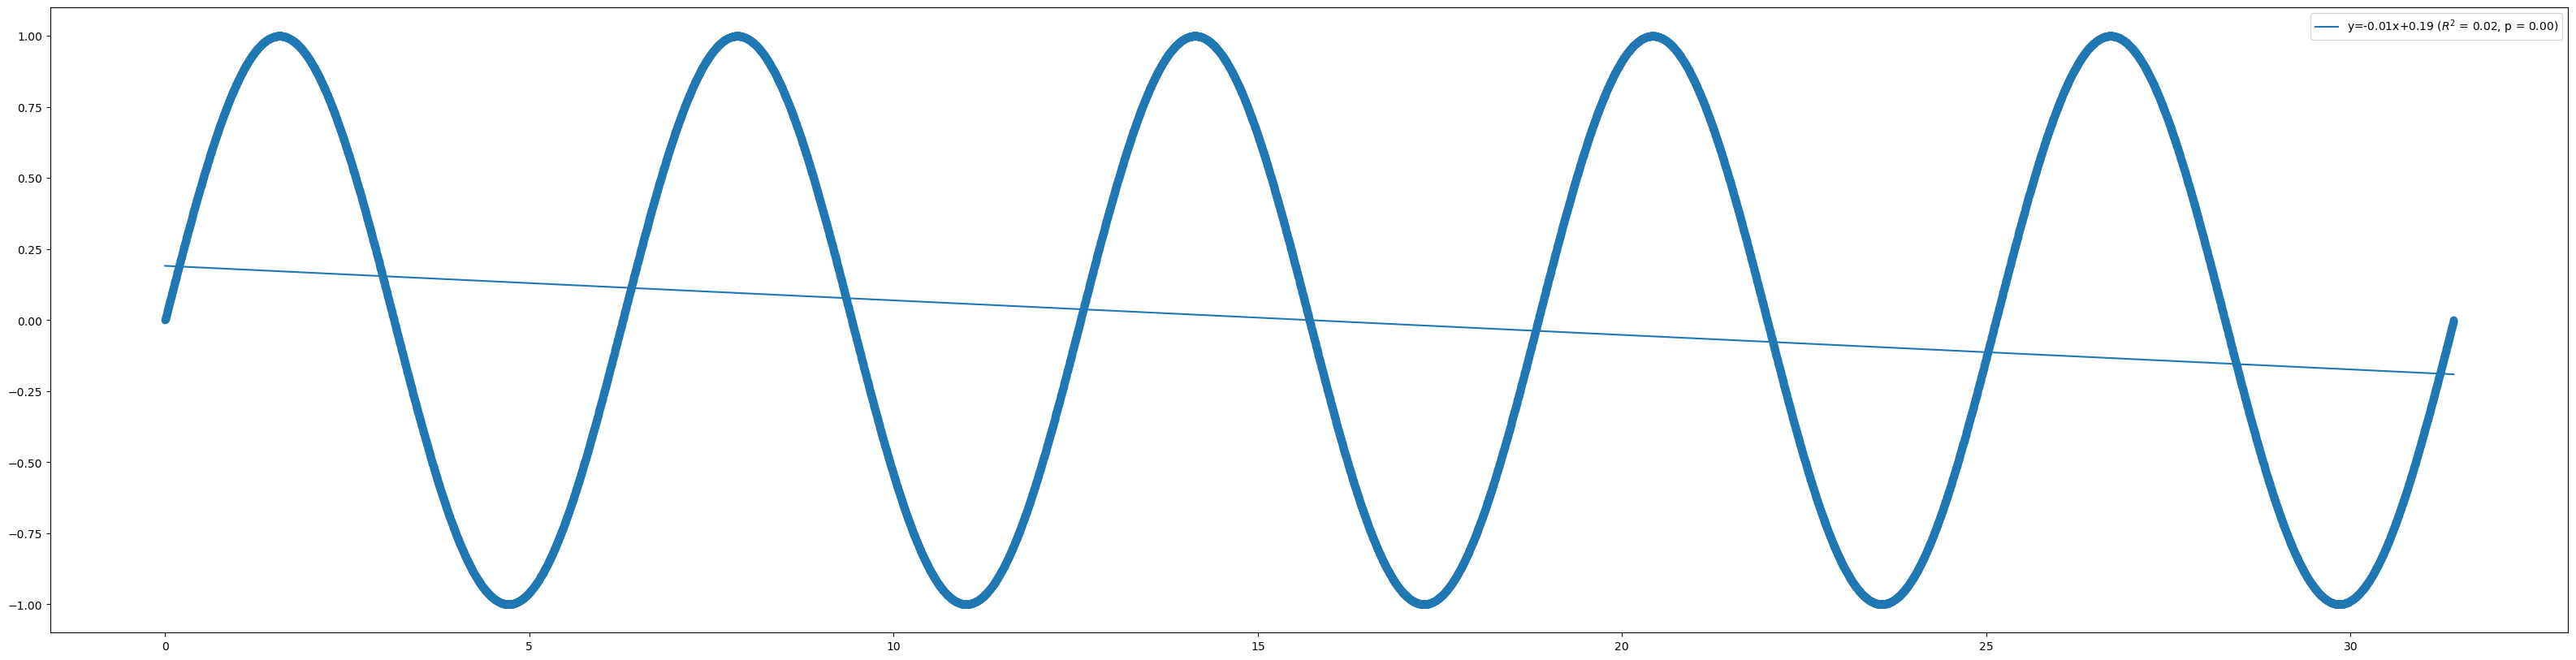

In [107]:
x = np.linspace(0, 10 * np.pi, 10000)
y = np.sin(x)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
fig, ax = plt.subplots(1, 1, figsize = (40, 10))
ax.scatter(x, y)
ax.plot(np.unique(x), np.unique(x) * slope + intercept, label=(rf"y={slope:.2f}x+{intercept:.2f} ($R^2$ = {r_value**2:.2f}, p = {p_value:.2f})"))
ax.legend()